<a href="https://colab.research.google.com/github/h403/EST2018/blob/master/EST2018Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# サンプルプログラム


Wi :  [1.12142481 1.32308617 1.57319414 1.93418878 2.42333744 3.13931722
 3.90956635 4.71234353 5.85869758 7.61603984]
Beta0l :  [1.98288448 1.4497801  1.72679143 1.72421995 1.35560999 1.62881118
 1.55905016 2.01230939 1.34837346 1.61033314]
Reference BW :  3.346801340345026
This design is satisfied the spec :  False
Score :  0


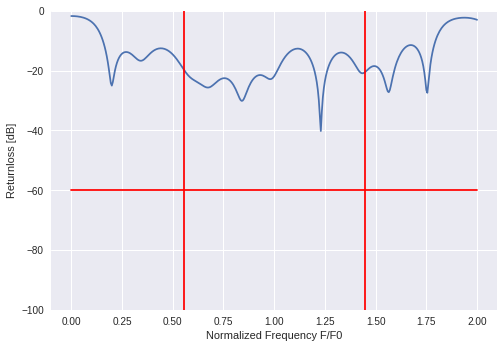

In [33]:
## ~~~~~~ 共用ライブラリ部分　ここから ~~~~~~
## ここは編集しないで各参加者のプログラムに貼り込んでください。

# 使用するライブラリ群のインポート
import matplotlib.pyplot as plt
import numpy as np
from scipy.special.orthogonal import chebyt
from scipy.optimize import bisect

NOF = 100001 # 基準帯域を計算する際に用いる計算点数

def db(x): # 真値からデシベルを計算する
  return 10 * np.log10(np.abs(x))

def inv_db(x): # デシベルから真値を計算する
    return 10**(x/10)

def calc_abcd_idealline(w,beta0l,freq): # 理想伝送線路のABCD行列
  m = np.zeros((len(freq),2,2),dtype=complex)
  betal = beta0l*freq
  m[:,0,0] = np.cos(betal)
  m[:,0,1] = 1j*w*np.sin(betal)
  m[:,1,0] = 1j/w*np.sin(betal)
  m[:,1,1] = np.cos(betal)
  return m

def calc_abcd_pary(y): # シャントアドミタンスのABCD行列
  m = np.zeros((2,2),dtype=complex)
  m[0,0] = 1.
  m[0,1] = 0.
  m[1,0] = y
  m[1,1] = 1.
  return m

def calc_gamma_wi(w,beta0l,r,freq): # 反射係数の計算
  abcd = calc_abcd_idealline(w[0],beta0l[0],freq) # 伝送線路のABCD行列の準備
  for wi,beta0li in zip(w[1:],beta0l[1:]): # 伝送線路部分の行列積の計算
    abcd = np.matmul(abcd,calc_abcd_idealline(wi,beta0li,freq))
  abcd = np.matmul(abcd,calc_abcd_pary(1./r)) # 終端抵抗部分の行列積の計算
  zin = abcd[:,0,0] / abcd[:,1,0] # ABCD行列から入力インピーダンスの計算
  return (zin - 1.) / (zin + 1.) # 入力インピーダンスから反射係数の計算

def calc_reference_bw(gamma_in_db,n,r): # 基準帯域 RBW の計算
    gamma = 10**(gamma_in_db/20.)
    rhs = 4*r/(r-1)**2*gamma**2/(1-gamma**2)
    tn = chebyt(n)
    tm = bisect(lambda x: tn(x)**2-1/rhs,1,10)**(-1)
    tm = np.arccos(tm)
    bw = np.pi / tm - 1
    return bw

def get_index_flfh(gamma_max_in_db,impedance_ratio,w,beta0l): # 下限・上限周波数の計算点番号の取得（内部利用）
    freq = np.linspace(0,2,NOF)
    gamma_in_db = 2*db(calc_gamma_wi(w,beta0l,impedance_ratio,freq))
    th = gamma_in_db > gamma_max_in_db
    th = np.where(th[1:] ^ th[:-1] == True)
    if len(th[0]) > 2:
        th = None
    else:
        th = th[0][0], th[0][1]+1
    return th

def calc_flfh(gamma_max_in_db,impedance_ratio,w,beta0l): # 下限・上限周波数の算出
    freq = np.linspace(0,2,NOF)
    index = get_index_flfh(gamma_max_in_db,impedance_ratio,w,beta0l)
    if index:
        flfh = freq[index[0]], freq[index[1]]
    else:
        flfh = None
    return flfh

def bw2flfh(bw): # バンド幅からの下限・上限周波数の算出
    fl = 2/(1+bw)
    fh = fl*bw
    return fl, fh

def is_satisfied_spec(gamma_max_in_db,impedance_ratio,w,beta0l,bandwidth,n_max):
    if len(w) > n_max:
        return False
    fl, fh = bw2flfh(bandwidth)
    freq = np.linspace(fl,fh,NOF)
    gamma_in_db = 2*db(calc_gamma_wi(w,beta0l,impedance_ratio,freq))
    if (gamma_in_db > gamma_max_in_db).sum():
        return False
    else:
        return True
    
def calc_score_core(gamma_max_in_db,impedance_ratio,w,beta0l): # スコア計算本体（内部利用）
    freq = np.linspace(0,2,NOF)
    gamma_in_db = 2*db(calc_gamma_wi(w,beta0l,impedance_ratio,freq))
    index = get_index_flfh(gamma_max_in_db,impedance_ratio,w,beta0l)
    if index:
        n = len(w)
        bw = freq[index[1]] / freq[index[0]]
        rbw = calc_reference_bw(gamma_max_in_db,n,impedance_ratio)
        score = bw / rbw * 100
    else:
        score = 0
    return score

def calc_score(gamma_max_in_db,impedance_ratio,w,beta0l,bandwidth,n_max): # スコア計算（これを呼んでください）
    if not is_satisfied_spec(gamma_max_in_db,impedance_ratio,w,beta0l,bandwidth,n_max):
        return 0
    return calc_score_core(gamma_max_in_db,impedance_ratio,w,beta0l)
  
  
## ~~~~~~ 共用ライブラリ部分　ここまで ~~~~~~
  
## ユーザープログラム部分。自由に改変していただいて構いません。

# 最適化関数 scipy.optimize.fmin のインポート
from scipy.optimize import fmin

# 設計仕様
R = 10. # インピーダンス変成比 RL/Z0
N_MAX = 10 # 用いる伝送線路の最大段数
GAMMA_MAX = -60 # 帯域内許容反射損失 [dB] 以下
BW_MIN = 2.61 # 最小整合帯域幅 FH/FL

# 最適化パラメータ
FL = 0.2 # 帯域の下限周波数
FREQ_OPT = np.linspace(FL,2-FL,401) # 最適化範囲内の正規化周波数リスト F/F0（401点）
N = 10 # 伝送線路の段数
w = 1 + np.random.rand(N)*(R - 1) # 各段の正規化特性インピーダンス（初期値）
beta0l = np.array([np.pi/2,]*N) # 各段の電気長 [ラジアン]（初期値）

## 最適化処理部分
def error(param,r,freq): # 誤差関数
    n = len(param) // 2
    w, beta0l = param[:n], param[n:]
    gamma = calc_gamma_wi(w,beta0l,r,freq)
    return np.sum(np.real(gamma * gamma.conj()))
# scipy.optimize.fmin 関数を用いて最適化する。結果は param に入る。
param = fmin(error,np.array([w,beta0l]).flatten(),args=(R,FREQ_OPT),disp=True)
w = param[:N] # param の前半 N 個の要素は正規化特性インピーダンスに相当する
beta0l = param[N:] # param の後半 N 個の要素は電気長に相当する

## 結果出力部分
print('Wi : ', w)
print('Beta0l : ', beta0l)
try:
  flfh = calc_flfh(GAMMA_MAX,R,w,beta0l)
  print('FL, FH : ', flfh)
  print('BW : ', flfh[1] / flfh[0])
except IndexError:
  pass
print('Reference BW : ', calc_reference_bw(GAMMA_MAX,N,R))
print('This design is satisfied the spec : ', is_satisfied_spec(GAMMA_MAX,R,w,beta0l,BW_MIN,N_MAX))
print('Score : ', calc_score(GAMMA_MAX,R,w,beta0l,BW_MIN,N_MAX))

FREQ = np.linspace(0,2,401) # グラフ表示する正規化周波数のリスト F/F0
plt.plot(FREQ,2*db(calc_gamma_wi(w,beta0l,R,FREQ)))
try:
  flfh = calc_flfh(GAMMA_MAX,R,w,beta0l)
  plt.plot([flfh[0],flfh[0]],[-100,0],'-g')
  plt.plot([flfh[1],flfh[1]],[-100,0],'-g')
except IndexError:
  pass
fl,fh = bw2flfh(BW_MIN)
plt.plot([0,2],[GAMMA_MAX,GAMMA_MAX],'-r')
plt.plot([fl,fl],[-100,0],'-r')
plt.plot([fh,fh],[-100,0],'-r')

plt.ylim(-100,0)
plt.xlabel('Normalized Frequency F/F0')
tmp = plt.ylabel('Returnloss [dB]')

# 課題提出用テンプレート


## 仕様１

Wi :  [1.06, 1.16, 1.31, 1.49, 1.67, 1.85]
Beta0l :  [1.55, 1.32, 1.51, 1.44, 1.5, 1.44]
FL, FH :  (0.27188, 1.8843400000000001)
BW :  6.930778284537296
Reference BW :  15.377225986175102
This design is satisfied the spec :  True
Score :  77.58710810944504


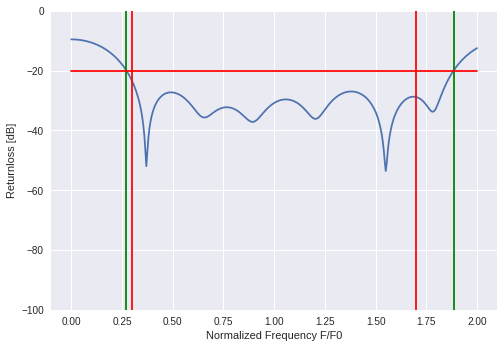

In [34]:
# 設計データ（ここを編集してください）
w = [1.06, 1.16, 1.31, 1.49, 1.67, 1.85]
beta0l = [1.55, 1.32, 1.51, 1.44, 1.50, 1.44]

# 設計仕様
R = 2. # インピーダンス変成比 RL/Z0
N_MAX = 6 # 用いる伝送線路の最大段数
GAMMA_MAX = -20 # 帯域内許容反射損失 [dB] 以下
BW_MIN = 5.7 # 最小整合帯域幅 FH/FL

## 結果出力部分
print('Wi : ', w)
print('Beta0l : ', beta0l)
try:
  flfh = calc_flfh(GAMMA_MAX,R,w,beta0l)
  print('FL, FH : ', flfh)
  print('BW : ', flfh[1] / flfh[0])
except IndexError:
  pass
print('Reference BW : ', calc_reference_bw(GAMMA_MAX,N,R))
print('This design is satisfied the spec : ', is_satisfied_spec(GAMMA_MAX,R,w,beta0l,BW_MIN,N_MAX))
print('Score : ', calc_score(GAMMA_MAX,R,w,beta0l,BW_MIN,N_MAX))

FREQ = np.linspace(0,2,401) # グラフ表示する正規化周波数のリスト F/F0
plt.plot(FREQ,2*db(calc_gamma_wi(w,beta0l,R,FREQ)))
try:
  flfh = calc_flfh(GAMMA_MAX,R,w,beta0l)
  plt.plot([flfh[0],flfh[0]],[-100,0],'-g')
  plt.plot([flfh[1],flfh[1]],[-100,0],'-g')
except IndexError:
  pass
fl,fh = bw2flfh(BW_MIN)
plt.plot([0,2],[GAMMA_MAX,GAMMA_MAX],'-r')
plt.plot([fl,fl],[-100,0],'-r')
plt.plot([fh,fh],[-100,0],'-r')

plt.ylim(-100,0)
plt.xlabel('Normalized Frequency F/F0')
tmp = plt.ylabel('Returnloss [dB]')

## 仕様２

Wi :  [1.06, 1.16, 1.31, 1.49, 1.67, 1.85]
Beta0l :  [1.55, 1.32, 1.51, 1.44, 1.5, 1.44]
Reference BW :  4.120347917550212
This design is satisfied the spec :  False
Score :  0


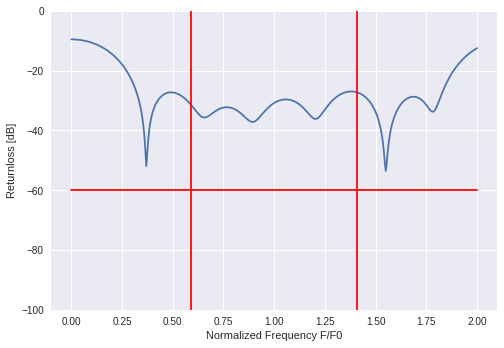

In [38]:
# 設計データ（ここを編集してください）
w = [1.06, 1.16, 1.31, 1.49, 1.67, 1.85]
beta0l = [1.55, 1.32, 1.51, 1.44, 1.50, 1.44]

# 設計仕様
R = 2. # インピーダンス変成比 RL/Z0
N_MAX = 8 # 用いる伝送線路の最大段数
GAMMA_MAX = -60 # 帯域内許容反射損失 [dB] 以下
BW_MIN = 2.38 # 最小整合帯域幅 FH/FL

## 結果出力部分
print('Wi : ', w)
print('Beta0l : ', beta0l)
try:
  flfh = calc_flfh(GAMMA_MAX,R,w,beta0l)
  print('FL, FH : ', flfh)
  print('BW : ', flfh[1] / flfh[0])
except IndexError:
  pass
print('Reference BW : ', calc_reference_bw(GAMMA_MAX,N,R))
print('This design is satisfied the spec : ', is_satisfied_spec(GAMMA_MAX,R,w,beta0l,BW_MIN,N_MAX))
print('Score : ', calc_score(GAMMA_MAX,R,w,beta0l,BW_MIN,N_MAX))

FREQ = np.linspace(0,2,401) # グラフ表示する正規化周波数のリスト F/F0
plt.plot(FREQ,2*db(calc_gamma_wi(w,beta0l,R,FREQ)))
try:
  flfh = calc_flfh(GAMMA_MAX,R,w,beta0l)
  plt.plot([flfh[0],flfh[0]],[-100,0],'-g')
  plt.plot([flfh[1],flfh[1]],[-100,0],'-g')
except IndexError:
  pass
fl,fh = bw2flfh(BW_MIN)
plt.plot([0,2],[GAMMA_MAX,GAMMA_MAX],'-r')
plt.plot([fl,fl],[-100,0],'-r')
plt.plot([fh,fh],[-100,0],'-r')

plt.ylim(-100,0)
plt.xlabel('Normalized Frequency F/F0')
tmp = plt.ylabel('Returnloss [dB]')

## 仕様３

Wi :  [1.06, 1.16, 1.31, 1.49, 1.67, 1.85]
Beta0l :  [1.55, 1.32, 1.51, 1.44, 1.5, 1.44]
Reference BW :  3.346801340345026
This design is satisfied the spec :  False
Score :  0


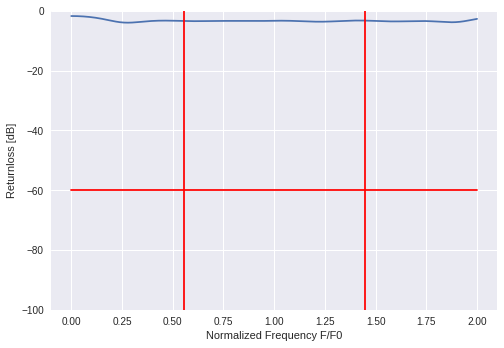

In [37]:
# 設計データ（ここを編集してください）
w = [1.06, 1.16, 1.31, 1.49, 1.67, 1.85]
beta0l = [1.55, 1.32, 1.51, 1.44, 1.50, 1.44]

# 設計仕様
R = 10. # インピーダンス変成比 RL/Z0
N_MAX = 10 # 用いる伝送線路の最大段数
GAMMA_MAX = -60 # 帯域内許容反射損失 [dB] 以下
BW_MIN = 2.61 # 最小整合帯域幅 FH/FL

## 結果出力部分
print('Wi : ', w)
print('Beta0l : ', beta0l)
try:
  flfh = calc_flfh(GAMMA_MAX,R,w,beta0l)
  print('FL, FH : ', flfh)
  print('BW : ', flfh[1] / flfh[0])
except IndexError:
  pass
print('Reference BW : ', calc_reference_bw(GAMMA_MAX,N,R))
print('This design is satisfied the spec : ', is_satisfied_spec(GAMMA_MAX,R,w,beta0l,BW_MIN,N_MAX))
print('Score : ', calc_score(GAMMA_MAX,R,w,beta0l,BW_MIN,N_MAX))

FREQ = np.linspace(0,2,401) # グラフ表示する正規化周波数のリスト F/F0
plt.plot(FREQ,2*db(calc_gamma_wi(w,beta0l,R,FREQ)))
try:
  flfh = calc_flfh(GAMMA_MAX,R,w,beta0l)
  plt.plot([flfh[0],flfh[0]],[-100,0],'-g')
  plt.plot([flfh[1],flfh[1]],[-100,0],'-g')
except IndexError:
  pass
fl,fh = bw2flfh(BW_MIN)
plt.plot([0,2],[GAMMA_MAX,GAMMA_MAX],'-r')
plt.plot([fl,fl],[-100,0],'-r')
plt.plot([fh,fh],[-100,0],'-r')

plt.ylim(-100,0)
plt.xlabel('Normalized Frequency F/F0')
tmp = plt.ylabel('Returnloss [dB]')